In [128]:
%load_ext autoreload
%autoreload 2

from scipy.stats import binom, beta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from contamination_estimation import VariantPosition, estimate_contamination, CONTAMINATION_RANGE
plt.rc('axes',labelsize=15)
# https://github.com/liguowang/dcon/blob/master/lib/DconModule/utils.py

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
VariantPosition(100,90,"HOM").log_contam_probability(0.1)

-2.02597397686619

In [135]:
def plot_result(vp, dist, sorted_likelihoods, simulated_contam):
    
    fig = plt.figure(figsize=(10,4))
    #plot simulated
    ax=fig.add_subplot(121)
    ys = [v.alt_depth/v.total_depth for v in vp]
    sns.histplot(ys, ax=ax, bins=50)
    ax.set_ylabel('Simulated variant count')
    ax.set_xlabel('Variant allele fraction')
    ax.set_xlim(0,1)

    #plot predicted
    ax=fig.add_subplot(122)
    contam_levels = list(dist.keys())
    loglik = np.array(list(dist.values()), dtype="float")
    prob = np.exp(loglik)
    posterior_prob = prob / prob.sum()
    ax.plot(contam_levels, posterior_prob)
    
    predicted_contam_level = sorted_likelihoods[-1][0]
    ax.vlines(x = predicted_contam_level, ymin=0, ymax=max(posterior_prob), color='red')
    ax.text(0.1, max(posterior_prob), "Simulating=%.3f; Estimated contam=%.3f" %(simulated_contam, predicted_contam_level), color='red', ha='left')
    ax.set_ylabel('Posterior Probability')
    ax.set_xlabel('Contamination level')
    fig.tight_layout()
    sns.despine()

Simulating: 0.0; Estimated: 0.009000000000000001
Simulating: 0.05; Estimated: 0.055
Simulating: 0.1; Estimated: 0.105
Simulating: 0.15000000000000002; Estimated: 0.153
Simulating: 0.2; Estimated: 0.203
Simulating: 0.25; Estimated: 0.255
Simulating: 0.30000000000000004; Estimated: 0.305
Simulating: 0.35000000000000003; Estimated: 0.353
Simulating: 0.4; Estimated: 0.399
Simulating: 0.45; Estimated: 0.399


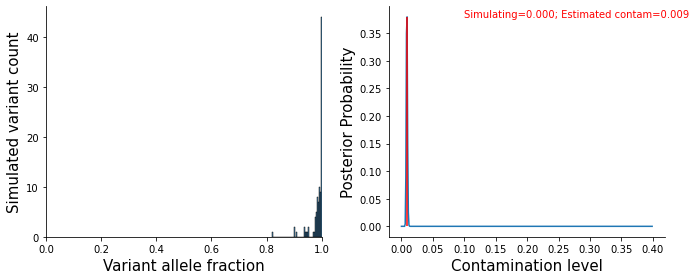

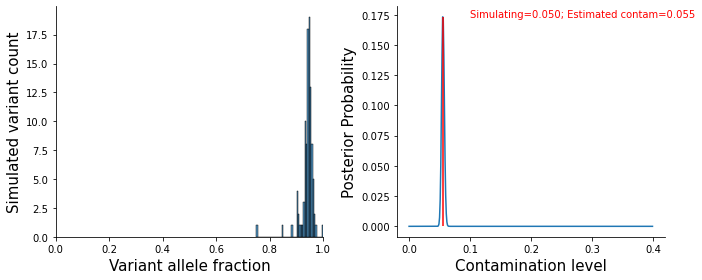

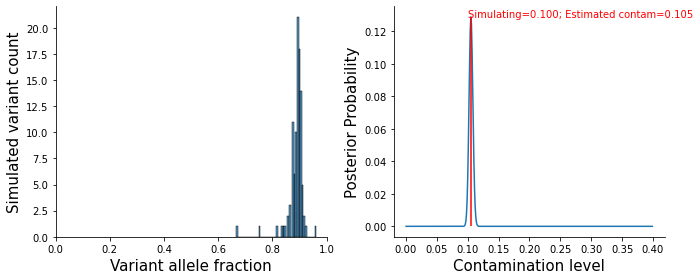

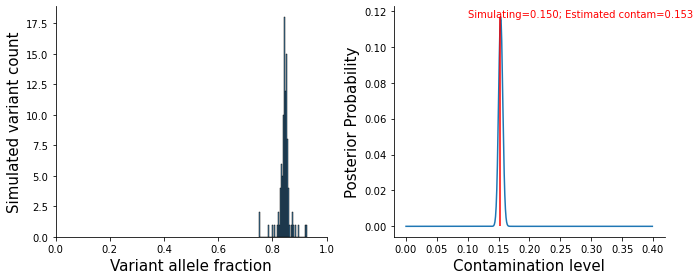

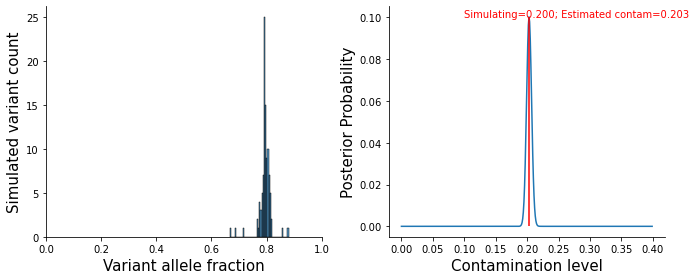

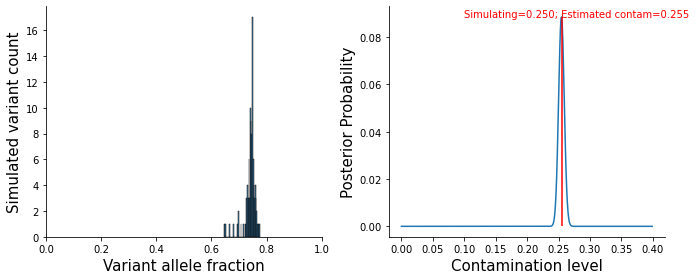

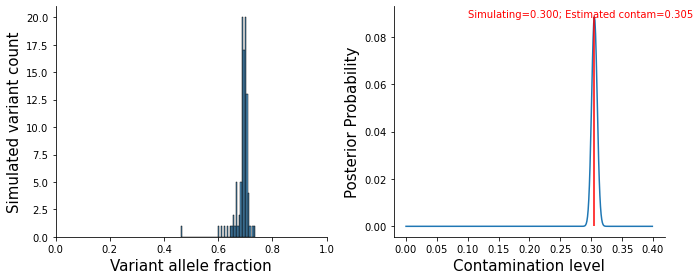

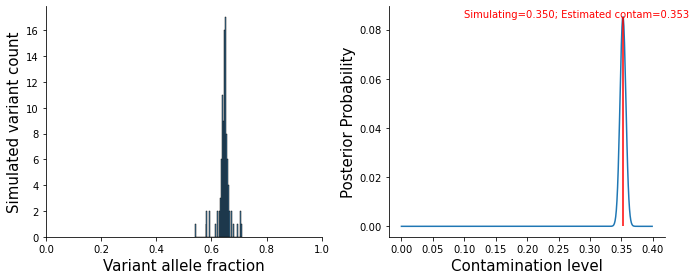

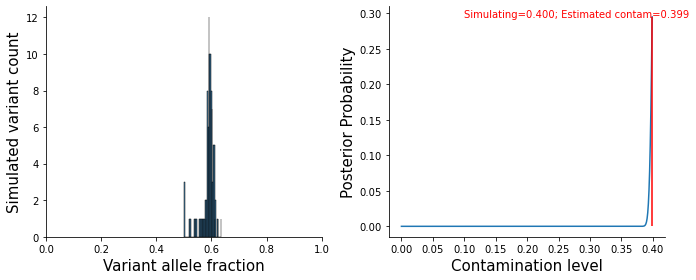

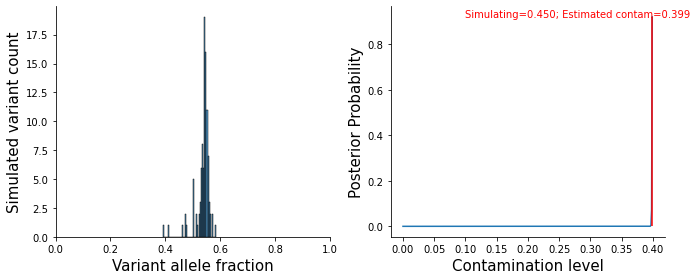

In [136]:
for simulated_contam in np.arange(0,0.5, 0.05):

    # simulate data HOM
    vp = []
    for i in range(100):
        total_depth = np.random.randint(10,200)
        alt_depth = total_depth - max(0, total_depth - np.random.normal(loc=total_depth * (1-simulated_contam) ))
        vp.append(
            VariantPosition(total_depth, alt_depth, 'HOM')
        )
    
    dist=estimate_contamination(vp)
    sorted_likelihoods = sorted(dist.items(), key=lambda k: k[1]) # ascending sort
    print(f"Simulating: {simulated_contam}; Estimated: {sorted_likelihoods[-1][0]}")
    plot_result(vp, dist, sorted_likelihoods, simulated_contam)
    

Simulating: 0.0; Estimated: 0.055
Simulating: 0.05; Estimated: 0.049
Simulating: 0.1; Estimated: 0.101
Simulating: 0.15000000000000002; Estimated: 0.146
Simulating: 0.2; Estimated: 0.198
Simulating: 0.25; Estimated: 0.395
Simulating: 0.30000000000000004; Estimated: 0.28700000000000003
Simulating: 0.35000000000000003; Estimated: 0.387
Simulating: 0.4; Estimated: 0.399
Simulating: 0.45; Estimated: 0.261


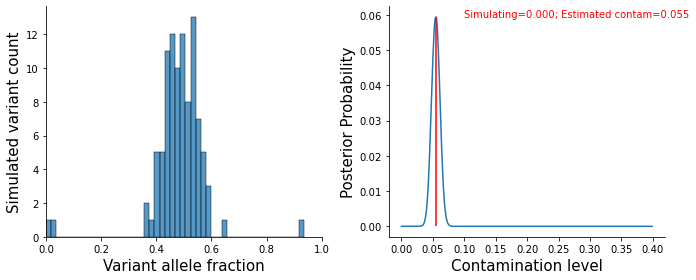

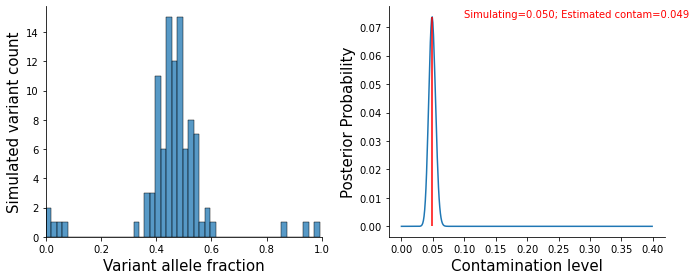

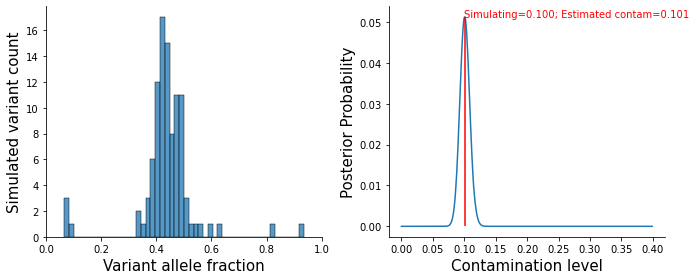

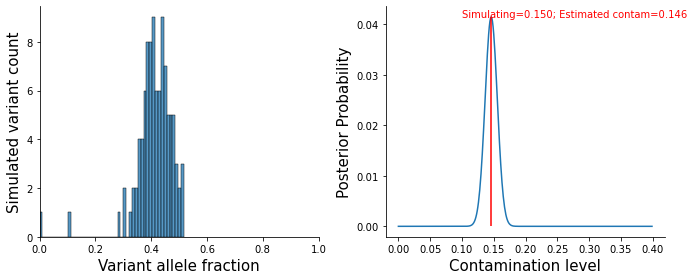

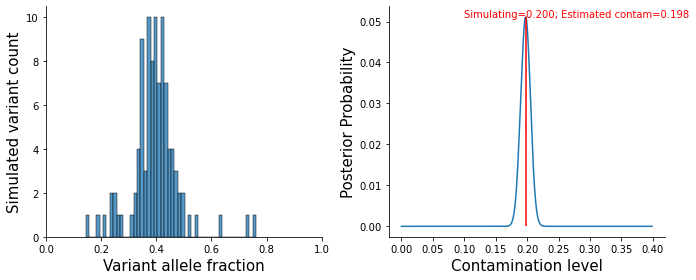

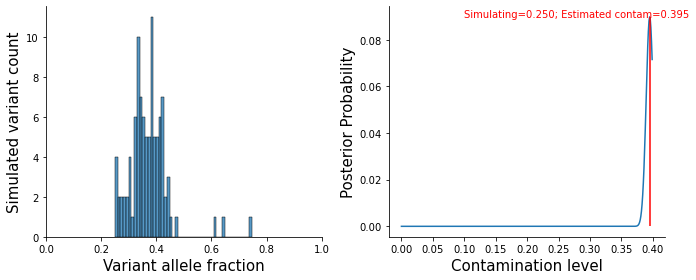

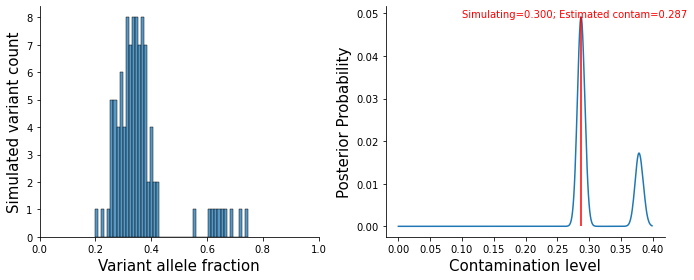

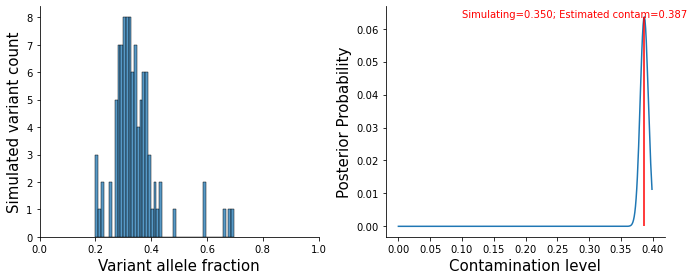

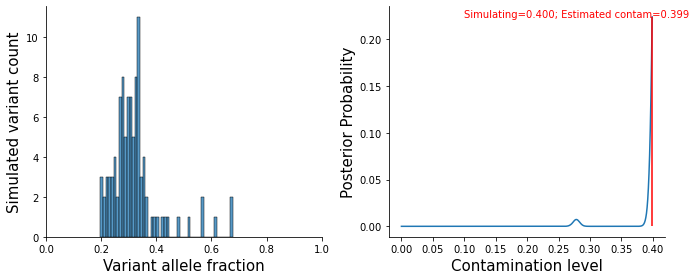

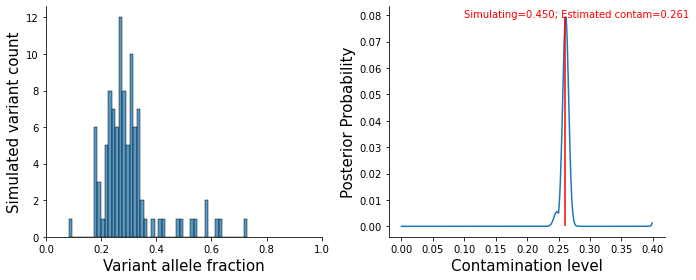

In [137]:
for simulated_contam in np.arange(0,0.5, 0.05):

    # simulate data HET
    vp = []
    for i in np.random.choice([1,2,3,4], size=100, p=[0.91, 0.03, 0.03, 0.03]):
        total_depth = np.random.randint(10,200)
        
        mode = i
        allele1_fraction = total_depth * 0.5
        alt_depth = total_depth / 2 
        scale = total_depth/20
        if mode == 1:# contam is not alt
            alt_depth = np.random.normal(loc=alt_depth * (1-simulated_contam), scale=scale ) 
        elif mode == 2:# contam looks like alt
            alt_depth = np.random.normal(loc=alt_depth * (1+simulated_contam), scale=scale ) 
        elif mode == 3:# contam is alt
            alt_depth = np.random.normal(loc=total_depth * simulated_contam, scale=scale ) 
        elif mode == 4:# HOM called as het because of contam
            alt_depth = np.random.normal(loc=total_depth * (1-simulated_contam), scale=scale ) 
        
        alt_depth = max(0.05, alt_depth) #gatk lowest is 0.05
        if alt_depth <= total_depth:
            vp.append(
                VariantPosition(total_depth, int(alt_depth), 'HET')
            )
    
    dist=estimate_contamination(vp)
    sorted_likelihoods = sorted(dist.items(), key=lambda k: k[1]) # ascending sort
    print(f"Simulating: {simulated_contam}; Estimated: {sorted_likelihoods[-1][0]}")
    
    plot_result(vp, dist, sorted_likelihoods, simulated_contam)

In [64]:
from contamination_estimation import estimate_vcf_contamination_level

In [65]:
estimate_vcf_contamination_level('data/test.vcf')

INFO:root:Processing 7 variants


0.08600000000000001